## Connexion à la base de données

In [1]:
import pyodbc
import pandas as pd

# Paramètres de connexion
server = 'LAPTOP-VAILS20L' 
database = 'DW_PI' 
username = 'sa'  
password = 'sa123' 
driver = '{SQL Server}'

# Connexion à SQL Server
try:
    conn = pyodbc.connect(
        f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'
    )
    print("Connexion réussie !")
except Exception as e:
    print("Erreur de connexion :", e)

Connexion réussie !


In [2]:
# Récupérer les données des tables
fact = pd.read_sql_query('SELECT TOP 1000 * FROM [DW_PI].[dbo].[fact_date2]', conn)
bac = pd.read_sql_query('SELECT * FROM [DW_PI].[dbo].[Dim_Bac]', conn)
diplome = pd.read_sql_query('SELECT * FROM [DW_PI].[dbo].[Dim_Diplome]', conn)
gouvernorat = pd.read_sql_query('SELECT * FROM [DW_PI].[dbo].[Dim_Gouvernorat]', conn)

# Fusionner les tables comme précédemment
df = fact.merge(bac[['Bac_Pk', 'nature_bac']], on='Bac_Pk', how='left')
df = df.merge(diplome[['Diplome_Pk', 'Diplome', 'Specialite']], on='Diplome_Pk', how='left')
df = df.merge(gouvernorat[['Gouv_PK', 'gouvernorat']], on='Gouv_PK', how='left')

# Garder les colonnes utiles
df = df[['score_final', 'moy_bac_et', 'nature_bac', 'Diplome', 'Specialite', 'gouvernorat', 'Admission']]

# Supprimer les lignes avec des valeurs manquantes
df.dropna(inplace=True)

# Afficher les premières lignes pour vérifier les données
print(df.head())

     score_final  moy_bac_et nature_bac            Diplome    Specialite  \
508         0.95       12.20       MATH  licence appliquée  informatique   
511        87.45       15.38       LETT  licence appliquée  informatique   
512        85.51       16.58       MATH  licence appliquée  informatique   
513        93.31       10.27       TECH  licence appliquée  informatique   
515        11.73       16.98      SPORT  licence appliquée  informatique   

     gouvernorat  Admission  
508       Le Kef          0  
511     Jendouba          1  
512       Nabeul          1  
513     Monastir         -1  
515  Sidi Bouzid         -1  


C:\Users\souha\AppData\Local\Temp\ipykernel_25796\973473603.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact = pd.read_sql_query('SELECT TOP 1000 * FROM [DW_PI].[dbo].[fact_date2]', conn)
C:\Users\souha\AppData\Local\Temp\ipykernel_25796\973473603.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bac = pd.read_sql_query('SELECT * FROM [DW_PI].[dbo].[Dim_Bac]', conn)
C:\Users\souha\AppData\Local\Temp\ipykernel_25796\973473603.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diplome = pd.read_sql_query('SELECT * 

## Encodage des variables catégorielles

In [3]:
from sklearn.preprocessing import LabelEncoder

# Liste des colonnes catégorielles
categorical_columns = ['nature_bac', 'Diplome', 'Specialite', 'gouvernorat']

# Initialiser le LabelEncoder
le = LabelEncoder()

# Encoder chaque colonne catégorielle
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Vérifier les premières lignes après encodage
print(df.head())


     score_final  moy_bac_et  nature_bac  Diplome  Specialite  gouvernorat  \
508         0.95       12.20           3        2           3            9   
511        87.45       15.38           2        2           3            5   
512        85.51       16.58           3        2           3           14   
513        93.31       10.27           6        2           3           13   
515        11.73       16.98           5        2           3           16   

     Admission  
508          0  
511          1  
512          1  
513         -1  
515         -1  


##  Séparation des données et normalisation

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Séparer les caractéristiques et la variable cible
X = df.drop('Admission', axis=1)  # Supprimer la colonne cible 'Admission'
y = df['Admission']  # Variable cible

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normaliser les données

# Vérifier les premières lignes des données normalisées
print(X_scaled[:5])


[[-1.78885009 -0.74701723  0.06600185  1.5868094   1.5744018  -0.22168808]
 [ 1.17739449  0.81062929 -0.48401355  1.5868094   1.5744018  -0.82084506]
 [ 1.11086831  1.39842043  0.06600185  1.5868094   1.5744018   0.52725814]
 [ 1.3783447  -1.69238131  1.71604805  1.5868094   1.5744018   0.3774689 ]
 [-1.41918401  1.59435081  1.16603265  1.5868094   1.5744018   0.82683663]]


## Application de KMeans

In [5]:
from sklearn.cluster import KMeans

# Appliquer KMeans
kmeans = KMeans(n_clusters=3, random_state=42)  # Choisir le nombre de clusters
kmeans.fit(X_scaled)

# Récupérer les prédictions (clusters) pour chaque échantillon
y_kmeans = kmeans.predict(X_scaled)

# Ajouter les prédictions au DataFrame
df['Cluster'] = y_kmeans

# Afficher les premiers résultats avec les clusters
print(df[['Admission', 'Cluster']].head())


C:\Users\souha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\souha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


     Admission  Cluster
508          0        0
511          1        0
512          1        0
513         -1        0
515         -1        0


Cluster
0    20
1    33
2    22
dtype: int64
Centres des clusters :
[[ 0.15131391  0.54857241  0.12100339  1.24482462  1.35410304 -0.1992197 ]
 [-0.30663186 -0.73825973  0.14933751 -0.07129865 -0.16128539  0.31846101]
 [ 0.32238969  0.60868741 -0.33400935 -1.02471077 -0.98907467 -0.29658271]]


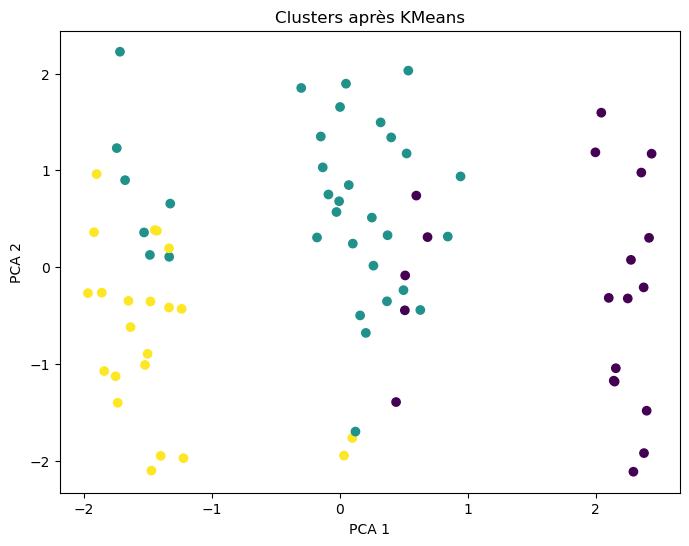

In [6]:
# Afficher la répartition des candidats par cluster
print(df.groupby('Cluster').size())

# Afficher les centres des clusters
print("Centres des clusters :")
print(kmeans.cluster_centers_)

# Visualisation des clusters (optionnel, si vous voulez visualiser les clusters)
import matplotlib.pyplot as plt

# Si vous avez plus de 2 dimensions, vous pouvez utiliser PCA pour réduire à 2 dimensions
from sklearn.decomposition import PCA

# Réduire à 2 dimensions avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualiser les clusters dans un graphique 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis')
plt.title('Clusters après KMeans')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


## Application du KNN 

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Essayer différents k
k_values = [3, 5, 7, 9, 11]
cv_scores = []

# Testons les performances pour chaque valeur de k avec validation croisée
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_val_score(knn, X_scaled, y_kmeans, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(cv_score))

# Afficher les résultats
for k, score in zip(k_values, cv_scores):
    print(f"Précision moyenne pour k={k}: {score:.4f}")
    
# Choisir le meilleur k (avec la meilleure précision moyenne)
best_k = k_values[np.argmax(cv_scores)]
print(f"\nLe meilleur k est: {best_k}")

# Entraîner le modèle final avec le meilleur k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_best = knn_best.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Exactitude avec le meilleur k ({best_k}) : {accuracy_best:.2f}")


Précision moyenne pour k=3: 0.8400
Précision moyenne pour k=5: 0.9067
Précision moyenne pour k=7: 0.9067
Précision moyenne pour k=9: 0.9067
Précision moyenne pour k=11: 0.9333

Le meilleur k est: 11
Exactitude avec le meilleur k (11) : 0.87


## TEST

In [16]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Entraîner le modèle avec le meilleur k
best_k = 11
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)  # X_train et y_train doivent être déjà préparés

# Dictionnaire d'interprétation
interpretation = {
    -1: 'REFUSE(E)',
    0: 'LISTE ATTENTE',
    1: 'ADMIS(E)'
}

# Fonction de prédiction
def predire_classification(moyenne_bac, score_final, nature_bac, diplome, specialite, gouvernorat):
    # Assurez-vous que toutes les caractéristiques sont incluses dans l'ordre
    features = [moyenne_bac, score_final, nature_bac, diplome, specialite, gouvernorat]
    
    # Prédiction de la classe avec le modèle KNN
    prediction = knn_best.predict([features])  # Notez que la prédiction retourne un tableau, donc [features] pour une instance
    return prediction[0]  # Retourner la première classe prédite (la seule dans ce cas)

# Exemple d'entrée
moyenne_bac = 14.5
score_final = 90.0
nature_bac = 1  # Nature du Bac (encodée)
diplome = 2     # Diplôme (encodé)
specialite = 3  # Spécialité (encodée)
gouvernorat = 4  # Gouvernorat (encodé)

# Test de la prédiction
predicted_class = predire_classification(moyenne_bac, score_final, nature_bac, diplome, specialite, gouvernorat)

# Afficher l'interprétation
print(f"Interprétation : {interpretation[predicted_class]}")

Interprétation : LISTE ATTENTE


In [17]:
import pickle

# Enregistrer le modèle dans un fichier pickle
with open('knn_model_Classification.pkl', 'wb') as f:
    pickle.dump(knn_best, f)


In [ ]:
import joblib

model_classification = joblib.load('knn_model_Classification.pkl')
